# Lab 6 - Gradient descent 
- **Author:** Qutub Khan Vajihi 
- **Date:** 3 March 2021
- **Course:** INFO 251: Applied machine learning

### Topics:
1. Batch Gradient Descent for OLS
2. Batch Gradient Descent for OLS in Matrix Form
2. Mini-Batch Gradient Descent


In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import IPython
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
from scipy import stats
%matplotlib inline

### Regression on Boston data

For this lab, let's keep using the [Boston Housing Prices Data Set](http://www.kellogg.northwestern.edu/faculty/weber/emp/_session_3/boston.htm).

In [2]:
from sklearn.datasets import load_boston
data = load_boston()
X = data.data
y = X[:,1] #target variable is ZN

##### For expediency, we're skipping the train-test splits here, but you should be doing those splits while working on the problem sets. 

In [3]:
# regress ZN on nitric oxides concentration 
X_NOX = X[:,4] #nitric oxides concentration (parts per 10 million)
Y = y 
n = len(y)
Xr = np.column_stack((np.ones(n), X_NOX))
# Get OLS closed form solution
beta_tilde = np.linalg.inv(np.matmul(Xr.T,Xr))@Xr.T@y
print("intercept and slope from closed form solution {}".format(beta_tilde))


intercept and slope from closed form solution [  69.038459   -103.97572805]


In [4]:
# Check with statsmodels
slope, intercept, r_value, p_value, std_err = stats.linregress(X_NOX,Y)
print("intercept and slope from scipy stats {}, {}".format(intercept, slope))

intercept and slope from scipy stats 69.03845900050108, -103.97572805288645


Both approaches give the same solution. Let's try it from scratch using Gradient Descent!

### Batch GD For OLS - 
OLS objective is $J(\alpha,\beta)=\frac{1}{2N}\sum_{i=1}^{N}(\alpha+\beta x_i-y_i)^2$ and its gradients are: 
\begin{align*}
&\frac{\partial J(\alpha,\beta)}{\partial \alpha}=\frac{1}{N}\sum_{i=1}^{N}(\alpha+\beta x_i -y_i)\\
&\frac{\partial J(\alpha,\beta)}{\partial \beta}=\frac{1}{N}\sum_{i=1}^{N}(\alpha+\beta x_i-y_i)x_i
\end{align*}

The GD update steps are:
\begin{align*}
&\alpha\leftarrow \alpha-R \frac{\partial J(\alpha,\beta)}{\partial \alpha}\\
&\beta\leftarrow \beta -R\frac{\partial J(\alpha,\beta)}{\partial \beta}
\end{align*}

In [5]:
# learning rate R, run GD for at most MaxIterations
def bivariate_ols(xvalues, yvalues, R=0.01, MaxIterations=1000):  
    # Initialize variablse
    xvalues = np.array(xvalues)
    yvalues = np.array(yvalues)
    alpha_new = 0.0
    beta_new = 0.0
    n = len(xvalues)
    # tolerance and iteration counter
    epsilon = 1e-6
    cnt = 0
    cost = np.inf
    for i in range(MaxIterations) : 
        # take GD update steps for as long as the values have not converged,
        alpha_old = alpha_new
        beta_old = beta_new
        cost_old = cost
        alpha_new = alpha_old - R / n * ((alpha_old + beta_old * xvalues - yvalues).sum())
        beta_new = beta_old - R / n * (((alpha_old + beta_old * xvalues - yvalues) * xvalues).sum())
        # you might want to print the cost to check it is descreasing
        cost = 1.0 / (2* n) * (((alpha_new + beta_new * xvalues - yvalues) ** 2).sum())
        # Here are the other stopping conditions
        if cost_old - cost < 0:
            print('Did not converge / Diverged')
            break
        if abs(alpha_new - alpha_old) < epsilon and abs(beta_new - beta_old) < epsilon:
            print('cost < epsilon stopped after iterations: {}'.format(i))
            break
        cnt += 1
        
    return alpha_new, beta_new, cnt

In [6]:
inter, slope, iters = bivariate_ols(X_NOX, Y, 0.01, 1000000)
print('intercept is {} and slope is {}'.format(inter, slope))


cost < epsilon stopped after iterations: 91109
intercept is 69.03297777184711 and slope is -103.96594755562221


In [7]:
inter, slope, iters = bivariate_ols(X_NOX, Y, 0.1, 1000000)
print('intercept is {} and slope is {}'.format(inter, slope))


cost < epsilon stopped after iterations: 11358
intercept is 69.03791144260042 and slope is -103.97475101126177


In [8]:
inter, slope, iters = bivariate_ols(X_NOX, Y, 100, 1000000)
print('intercept is {} and slope is {}'.format(inter, slope))


Did not converge / Diverged
intercept is -138598.96371176216 and slope is -77816.82731818825


### Batch GD For OLS in Matrix Form -
OLS objective is $J(\alpha,\beta)=\frac{1}{2N}||Y-\alpha-X\beta||^2$ and its gradients are: 
\begin{align*}
&\frac{\partial J(\alpha,\beta)}{\partial \alpha}=\frac{1}{N}(Y-\alpha -X\boldsymbol\beta).sum() \\
&\frac{\partial J(\alpha,\beta)}{\partial \beta}=\frac{1}{N}(X^TY-X^T\alpha-X^TX\boldsymbol\beta)=\frac{1}{N}X^T	(Y-\alpha -X\boldsymbol\beta)
\end{align*}

The GD update steps are:
\begin{align*}
&\alpha\leftarrow \alpha-R \frac{\partial J(\alpha,\beta)}{\partial \alpha}\\
&\beta\leftarrow \beta -R\frac{\partial J(\alpha,\beta)}{\partial \beta}
\end{align*}

In [12]:
def multivariate_ols(xvalue_matrix, yvalues, R=0.01, MaxIterations=1000):
    start_time = time.time()
    xvalue_matrix = np.array(xvalue_matrix)
    yvalues = np.array(yvalues)[:, np.newaxis]
    n, variable_n = xvalue_matrix.shape
    alpha = 0.0
    beta_array = np.transpose(np.array([[0.0] * variable_n]))
    cost = np.inf
    epsilon = 1e-6
    for i in range(MaxIterations):
        cost_old = cost
        alpha_old = alpha
        beta_array_old = np.copy(beta_array)
        
        part_1 = alpha_old + np.dot(xvalue_matrix, beta_array_old) - yvalues
        
        alpha -= R / n * (part_1.sum())
        beta_array -= R / n * (np.dot(xvalue_matrix.T, part_1))
        
        part_2 = alpha + np.dot(xvalue_matrix, beta_array) - yvalues
        cost = 1.0 / (2 * n) * ((part_2 ** 2).sum())
        
        if cost_old - cost < 0:
            print('not converge stopped after iteration times: {}'.format(i))
            break
        if abs(alpha-alpha_old) < epsilon and max(abs(beta_array-beta_array_old)) < epsilon:
            print('cost < epsilon stopped after iteration times: {}'.format(i))
            break
    print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    return alpha, beta_array

In [13]:
X = data.data
X = np.array(X[:,[4,5]])
Xr = np.column_stack((np.ones(n), X))
# Get OLS closed form solution
beta_tilde = np.linalg.inv(np.matmul(Xr.T,Xr))@Xr.T@y
print("intercept and slope from closed form solution {}".format(beta_tilde))

intercept and slope from closed form solution [ 27.465243   -93.54228584   5.69417964]


In [17]:
X

array([[0.538, 6.575],
       [0.469, 6.421],
       [0.469, 7.185],
       ...,
       [0.573, 6.976],
       [0.573, 6.794],
       [0.573, 6.03 ]])

In [14]:
alpha, beta_array = multivariate_ols(X, Y, 0.1, 1000000)
print('intercept is {} and slope is {}'.format(alpha, beta_array))

not converge stopped after iteration times: 1
Time taken: 0.00 seconds
intercept is -2.6770655473826137 and slope is [[ -1.74550179]
 [-16.17969466]]


In [131]:
alpha, beta_array = multivariate_ols(X, Y, 0.01, 1000000)
print('intercept is {} and slope is {}'.format(alpha, beta_array))

cost < epsilon stopped after iteration times: 154486
Time taken: 3.51 seconds
intercept is 27.44610341120165 and slope is [[-93.52973197]
 [  5.69610115]]


### Mini-Batch GD for OLS in Matrix Form - 


In [18]:
from sklearn.utils import shuffle
def MBGD_multivariate_ols(xvalue_matrix, yvalues, R, MaxIterations, BATCH_SIZE):
    start_time = time.time()
    xvalue_matrix = np.array(xvalue_matrix)
    yvalues = np.array(yvalues)[:, np.newaxis]
    n, variable_n = xvalue_matrix.shape 
    alpha = 0.0
    beta_array = np.transpose(np.array([[0.0] * variable_n]))
    cost = np.inf
    epsilon = 1e-6
    cost_l = []
    for i in range(MaxIterations):
        cost_old = cost
        alpha_old = alpha
        beta_array_old = np.copy(beta_array) 
        X, y = shuffle(xvalue_matrix, yvalues)
        for offset in range(0, n, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X[offset:end], y[offset:end]
            part_1 = alpha_old + np.dot(batch_x, beta_array_old) - batch_y 
            alpha -= R / n * (part_1.sum())
            beta_array -= R / n * (np.dot(batch_x.T, part_1))
            part_2 = alpha + np.dot(batch_x, beta_array) - batch_y 
            cost = 1.0 / (2 * n) * ((part_2 ** 2).sum())
            cost_l.append(cost)
        if abs(alpha-alpha_old) < epsilon and max(abs(beta_array-beta_array_old)) < epsilon:
            print('cost < epsilon stopped after iteration times: {}'.format(i))
            break
    print("Time taken: {:.2f} seconds".format(time.time() - start_time))
    return alpha, beta_array

#### Let's standardize this time before proceeding

In [134]:
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

In [135]:
X = data.data
X = np.array(X[:,[4,5]])
X = standardize(X)
Xr = np.column_stack((np.ones(n), X))
# Get OLS closed form solution
beta_tilde = np.linalg.inv(np.matmul(Xr.T,Xr))@Xr.T@y
print("intercept and slope from closed form solution {}".format(beta_tilde))

intercept and slope from closed form solution [ 11.36363636 -10.82874643   3.99687289]


In [136]:
batch_size = 16
X = data.data
X = np.array(X[:,[4,5]])
X = standardize(X)
alpha, beta_array = MBGD_multivariate_ols(X, Y, 0.1, 1000000, batch_size)
print('intercept is {} and slope is {}'.format(alpha, beta_array))

cost < epsilon stopped after iteration times: 172
Time taken: 0.10 seconds
intercept is 11.363636225765829 and slope is [[-10.82873388]
 [  3.99688544]]


### EXTRA - Simple 2D Example of GD
Feel free to try your own two input function to build intuition on GD.

$J=J_1(x,y)=\frac{x^2}{8}+y^2$  where I use $x,y$ for $x$ and $y$ coordinate or $z_1,z_2$ as in slides

perform gradeint descent on this function.
Gradients are :
$\frac{\partial J_1(x,y)}{\partial x}=2x/8$ and  $\frac{\partial J_1(x,y)}{\partial y}=2y$

Also provided $J_2(x,y) = (1.5-x-xy)^2+(2.25-x-xy^2)^2+(2.626-x-xy^3)^3$

In [97]:
def func_z(x, y):
    # Simple function with 2 inputs
    # Calculate values of Z from the created grid
    # feel free to check other functions too
    z = x**2/8+y**2 # call this f1
    #z = (1.5-x+x*y)**2+(2.25-x+x*y**2)**2+(2.625-x+x*y**3)**2 # call this f2
    return z

def gradient_descent(px, py, learning_rate, epoch):
    x_gd = []
    y_gd = []
    z_gd = []
    x_gd.append(px) # 1st coordinate
    y_gd.append(py)  # 2nd coordinate
    z_gd.append(func_z(px, py)) # value of function
    # begin the loops to update x, y and z
    for i in range(epoch):
        #der_x = 2*(1.5-px+px*py)*(py-1)+2*(2.25-px+px*py**2)*(py**2-1)+2*(2.625-px+px*py**3)*(py**3-1) # for f2
        #der_y = 2*(1.5-px+px*py)*px+2*(2.25-px+px*py**2)*(2*py*px)+2*(2.625-px+px*py**3)*(3*py**2*px) # for f2
        der_x = 2*px/8
        der_y = 2*py
        px = px - learning_rate * der_x
        x_gd.append(px)
        py = py - learning_rate * der_y
        y_gd.append(py)
        z_gd.append(func_z(px, py))
    return x_gd, y_gd, z_gd

In [98]:
x0 = 2.1
y0 = 2
learning_rate = 0.92
epoch = 1500
''' Plot our function '''
a = np.arange(-4, 4, 0.05)
b = np.arange(-4, 4, 0.05)

x, y = np.meshgrid(a, b)
z = func_z(x, y)



### Plot the function

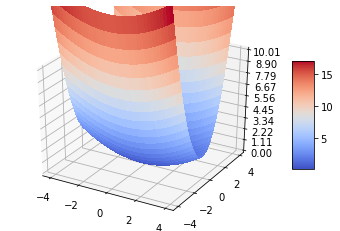

In [99]:
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

 # Customize the z axis.

ax.set_zlim(-0.0, 10.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

#Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

### Plot the convergence of GD

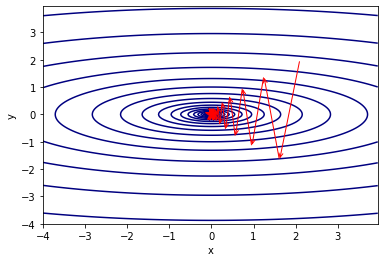

In [100]:

fig1, ax1 = plt.subplots()
ax1.contour(x, y, z, levels=np.logspace(-4, 4, 35), cmap='jet')
#Plot target (the minimum of the function)
min_point = np.array([3.0, 0.5])
min_point_ = min_point[:, np.newaxis]
ax1.plot(0.0, 0.0, 'r*', markersize=12) #This is the min for f1
#ax1.plot(3.0, 0.5, 'r*', markersize=12) #This is the min for f2
ax1.set_xlabel(r'x')
ax1.set_ylabel(r'y')
x_gd, y_gd, z_gd = gradient_descent(x0, y0, learning_rate, epoch)
for i in range(1, epoch+1):
   ax1.annotate('', xy=(x_gd[i], y_gd[i]), xytext=(x_gd[i-1], y_gd[i-1]),
                  arrowprops={'arrowstyle': '->', 'color': 'r', 'lw': 1},
                  va='center', ha='center')

''' Animation '''
# Create animation
line, = ax1.plot([], [], 'r', label = 'Gradient descent', lw = 1.5)
point, = ax1.plot([], [], 'bo')
value_display = ax1.text(0.02, 0.02, '', transform=ax1.transAxes)

plt.show()